# Semantic Segmentation

### by Wenzhe Ding

Semantic Segmentation refers to the task of assigning meaning to an object. We could using semantic segmentation to assign **each pixel** to a target class such as road, car, pedestrain, traffic sign, or any number of other classes.

![Semantic Segmentation](https://github.com/wzding/Self_Driving_Car_Nanodegree/blob/master/Semantic-Segmentation/images/semantic_segmentation.png?raw=true)

In this project, we'll label the pixels of a road in images using a Fully Convolutional Network (FCN). 

## Table of contents
- [Fully Convolutional Networks](#FCN)
- [Implementation](#Implementation)
- [Create a video from output images](#Video)

In [12]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

----
<a id='FCN'></a>
## Fully Convolutional Networks
[[ go back to the top ]](#Table-of-contents)


We’ll discuss the [FCN-8 architecture developed at Berkeley](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf). In fact, many FCN models are derived from this FCN-8 implementation. There are four steps of a FCN model.

1. Encoder. The encoder for FCN-8 is the VGG16 model pretrained on ImageNet for classification. The fully-connected layers are replaced by 1-by-1 convolutions. 
2. Decoder. We need to upsample the input to the original image size. The shape of the tensor after the final convolutional transpose layer will be 4-dimensional: (batch_size, original_height, original_width, num_classes). 
3. Skip Connections. We combine the output of two layers. The first output is the output of the current layer. The second output is the output of a layer further back in the network, typically a pooling layer.
4. define a loss. Using cross entropy loss, we can approach training a FCN just like we would approach training a normal classification CNN.

----
<a id='Implementation'></a>
## Implementation
[[ go back to the top ]](#Table-of-contents)

We use [Kitti Road dataset](http://www.cvlibs.net/datasets/kitti/eval_road.php) for this project, the dataset can be downloaded [here](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/advanced_deep_learning/data_road.zip).
Note that it's better to use a GPU for this project. We use a pretrained VGG Model and cross entropy loss as the loss function for this project. 

In [23]:
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

In [24]:
# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

In [14]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # Done: Implement function
    #   Use tf.saved_model.loader.load to load the model and weights
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    graph = tf.get_default_graph()
    image_input = graph.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    layer3_out = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4_out = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7_out = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
    return image_input, keep_prob, layer3_out, layer4_out, layer7_out
tests.test_load_vgg(load_vgg, tf)

Tests Passed


In [15]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer3_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer7_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    std = 1e-3
    regularizer = 1e-3
    # DONE: Implement function
    conv_1x1_1st = tf.layers.conv2d(vgg_layer7_out, num_classes, 1, 1,
                                  padding='same',
                                  kernel_initializer = tf.random_normal_initializer(stddev=std),
                                  kernel_regularizer=tf.contrib.layers.l2_regularizer(regularizer))
    upsamplex2_1st = tf.layers.conv2d_transpose(conv_1x1_1st, num_classes, 4, 2,
                                              padding= 'same',
                                              kernel_initializer = tf.random_normal_initializer(stddev=std),
                                              kernel_regularizer=tf.contrib.layers.l2_regularizer(regularizer))
    conv_1x1_2nd = tf.layers.conv2d(vgg_layer4_out, num_classes, 1, 1,
                                  padding = 'same',
                                  kernel_initializer = tf.random_normal_initializer(stddev=std),
                                  kernel_regularizer=tf.contrib.layers.l2_regularizer(regularizer))
    # Adding skip layer.
    skip_1st = tf.add(upsamplex2_1st, conv_1x1_2nd)
    # Upsample deconvolutions x 2.
    upsamplex2_2nd = tf.layers.conv2d_transpose(skip_1st,
                                                num_classes,
                                                4, 2,
                                                padding= 'same',
                                                kernel_initializer = tf.random_normal_initializer(stddev=std),
                                                kernel_regularizer= tf.contrib.layers.l2_regularizer(regularizer))
    conv_1x1_3rd = tf.layers.conv2d(vgg_layer3_out,
                                    num_classes, 1, 1,
                                    padding = 'same',
                                    kernel_initializer = tf.random_normal_initializer(stddev=std),
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(regularizer))
    # Adding skip layer.
    skip_2nd = tf.add(upsamplex2_2nd, conv_1x1_3rd)
    # Upsample deconvolution x 8.
    upsamplex8_3rd = tf.layers.conv2d_transpose(skip_2nd,
                                                num_classes, 16, 8,
                                                padding= 'same',
                                                kernel_initializer = tf.random_normal_initializer(stddev=std),
                                                kernel_regularizer= tf.contrib.layers.l2_regularizer(regularizer))
    return upsamplex8_3rd
tests.test_layers(layers)

Tests Passed


In [16]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # DONE: Implement function
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    correct_label = tf.reshape(correct_label, (-1, num_classes))
    # loss function.
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                labels=correct_label))
    # Define optimizer. Adam in this case to have variable learning rate.
    optimizer = tf.train.AdamOptimizer(learning_rate)
    # Apply optimizer to the loss function.
    train_op = optimizer.minimize(cross_entropy_loss)
    return logits, train_op, cross_entropy_loss
tests.test_optimize(optimize)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Tests Passed


In [17]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    # Done: Implement function
    sess.run(tf.global_variables_initializer())
    print('Starting training ...')
    for epc in range(epochs):
        print('Epoch : {}'.format(epc + 1))
        loss_log = []
        for image, label in get_batches_fn(batch_size):
            __, loss = sess.run([train_op, cross_entropy_loss],
                                feed_dict={
                                    input_image: image,
                                    correct_label: label,
                                    keep_prob: 0.5,
                                    learning_rate: 0.00001})
            # print(__, loss)
            loss_log.append(loss)
        print("Losses are", loss_log)
    print('Finished traning')

tests.test_train_nn(train_nn)


In [22]:
num_classes = 2
image_shape = (160, 576)
data_dir = './data'
runs_dir = './runs'
tests.test_for_kitti_dataset(data_dir)

In [21]:
# Download pretrained vgg model
helper.maybe_download_pretrained_vgg(data_dir)

with tf.Session() as sess:
    # Path to vgg model
    vgg_path = os.path.join(data_dir, 'vgg')
    # Create function to get batches
    get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'training'), image_shape)

    # OPTIONAL: Augment Images for better results
    #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

    # DONE: Build NN using load_vgg, layers, and optimize function
    correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes], name='correct_label')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    input_image, keep_prob, layer3_out, layer4_out, layer7_out = load_vgg(sess, vgg_path)
    # Creating new layers.
    layer_output = layers(layer3_out, layer4_out, layer7_out, num_classes)
    # Creating loss and optimizer operations.
    logits, train_op, cross_entropy_loss = optimize(layer_output, correct_label, learning_rate, num_classes)

    # DONE: Train NN using the train_nn function
    epochs = 48 # 6 12 24
    batch_size = 5
    train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate)

    # DONE: Save inference data using helper.save_inference_samples
    helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)

One sample output is shown below. It is clear that the edge of the road is detected in pixels.

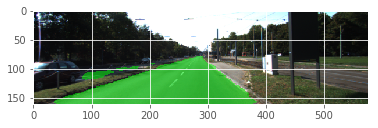

In [13]:
from PIL import Image
image = Image.open(runs_dir + '/um_000000.png')
plt.imshow(image) 

----
<a id='Video'></a>
## Create a video from output images
[[ go back to the top ]](#Table-of-contents)


Finally run our pipeline on this short video below.

In [1]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
def image_to_video(images_folder):
    clip = ImageSequenceClip(images_folder, load_images=True, fps=5)
    clip.write_videofile('semantic_segmentation_result.mp4')

In [20]:
images_folder = "runs/"
image_to_video(images_folder)

Run an object detection pipeline on the above clip using MobileNet SSD.

In [2]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('https://github.com/wzding/Self_Driving_Car_Nanodegree/raw/master/Semantic-Segmentation/result.mp4'))